In [407]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, wilcoxon
import seaborn as sns
import statsmodels.api as sm

In [408]:
df = pd.read_csv(r'\\mosfil02.int.tgr.net\UsersFolders$\gpe9038\Desktop\ROSTICS-LAB\project\static\test_data\data_1.csv')
clusters = pd.read_csv(r'\\mosfil02.int.tgr.net\UsersFolders$\gpe9038\Desktop\ROSTICS-LAB\project\static\clustered_results.csv')
clusters = clusters.rename(columns={'Fact ID': 'restraunt_id', 'Combined_Cluster': 'strat', 'action_order_success': 'TRX', 'Group': 'group'})[['restraunt_id', 'TRX', 'strat']]

#clusters.restraunt_id = clusters[clusters.restraunt_id.isin(sort)].restraunt_id
#clusters = clusters.dropna()

data = df.merge(clusters, on='restraunt_id')
data['event_date'] = data['event_date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").strftime("%Y-%m-%d"))
grouped_size = clusters.groupby('strat').size().to_frame(name='strat_size')
clusters = pd.merge(clusters, grouped_size, on='strat')

clusters


,restraunt_id,TRX,strat,strat_size
0,74021462,4863,0.0_0.0,8
1,74021157,4737,0.0_0.0,8
2,74020799,4930,0.0_0.0,8
3,74021880,4904,0.0_0.0,8
4,74221444,4794,0.0_0.0,8
5,74021513,4713,0.0_0.0,8
6,74021620,4719,0.0_0.0,8
7,74321843,4725,0.0_0.0,8
8,74021836,13018,0.0_1.0,8
9,74221447,13387,0.0_1.0,8


In [409]:
clusters.strat.nunique()

2

In [410]:
common_config = {
    'dbname': 'db',
    'user': 'codespace',
    'host': 'localhost',
    'project': 'kfc-kiosk-3',
    'location': 'US',
    'query_id': 'bquxjob_159f1b6a_18cedf71333',
    'kiosk_path': '/workspaces/codespaces-blank/bquxjob_567f0b61_18cf4ee3d07.csv',
    'cc_path': '/workspaces/codespaces-blank/cc.xlsx',
    'kassa_path': '/workspaces/codespaces-blank/kassa.xlsx',
    'name': 'ab_test_2',
    'start_date': '2023-12-15',
    'data_collect_start_date': '2023-01-08',
    'data_collect_end_date': '2024-01-08',
    'lower_bound': 0,
    'upper_bound': 1
}

In [411]:
print(data.event_date.min(), 'начало')
print(data.event_date.max(), 'конец')

2023-11-06 начало
2024-01-08 конец


In [412]:
#data[config['aggregator']] = np.log(data[data[config['aggregator']] > 0][config['aggregator']])

In [413]:
data

,event_date,restraunt_id,session_count,tap_auth_count,tap_email_count,tap_sms_count,action_order_start,action_order_success,action_auth_order_success,revenue,avg_product_count,conversion_rate_total,conversion_rate_auth,TRX,strat
0,2023-12-18,74020661,223,0,0,0,223,175,2,80192.0,2.925714,0.784753,0.008969,13225,0.0_1.0
1,2023-12-18,74021762,267,0,0,0,267,201,6,82278.0,2.870647,0.752809,0.022472,13124,0.0_1.0
2,2023-12-18,74321843,81,0,0,0,81,59,1,33133.0,3.355932,0.728395,0.012346,4725,0.0_0.0
3,2023-12-19,74020661,239,0,0,0,239,177,1,92104.0,3.412429,0.740586,0.004184,13225,0.0_1.0
4,2023-12-21,74221447,324,0,0,0,324,264,6,165225.0,3.363636,0.814815,0.018519,13387,0.0_1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,2023-11-15,74021513,143,0,0,0,143,97,2,50504.0,3.989691,0.678322,0.013986,4713,0.0_0.0
904,2023-11-15,74021880,139,0,0,0,139,98,1,76116.0,3.938776,0.705036,0.007194,4904,0.0_0.0
905,2023-11-11,74021157,151,0,0,0,151,74,1,40267.0,3.459459,0.490066,0.006623,4737,0.0_0.0
906,2023-11-11,74021513,61,0,0,0,61,48,0,26198.0,4.479167,0.786885,0.000000,4713,0.0_0.0


In [486]:
def calc_strat_mean(df: pd.DataFrame, weights: pd.Series, config) -> float:
    """Считает стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_mean = df.groupby('strat')[config['aggregator']].mean()
    return (strat_mean * weights).sum()


def calc_strat_var(df: pd.DataFrame, weights: pd.Series, config) -> float:
    """Считает стратифицированную дисперсию.
    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_var = df.groupby('strat')[config['aggregator']].var()
    #print(strat_var)
    return (strat_var * weights**2).sum()


def ttest_strat(a: pd.DataFrame, b: pd.DataFrame, weights: pd.Series, config) -> float:
    """Возвращает pvalue теста Стьюдента для стратифицированного среднего.

    a, b - данные пользователей контрольной и экспериментальной групп
    weights - маппинг {название страты: вес страты в популяции}
    """
    a_strat_mean = calc_strat_mean(a, weights, config)
    b_strat_mean = calc_strat_mean(b, weights, config)
    a_strat_var = calc_strat_var(a, weights, config)
    b_strat_var = calc_strat_var(b, weights, config)
    delta = b_strat_mean - a_strat_mean
    std = (a_strat_var / len(a) + b_strat_var / len(b)) ** 0.5
    t = delta / std
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))
    #print(a.count(), b.count())

    #sample size
    strat_mean = calc_strat_mean(pd.concat([a, b]), weights, config)
    strat_var = calc_strat_var(pd.concat([a, b]), weights, config)

    effect = config['MDE']/100 * strat_mean

    t_alpha = stats.norm.ppf(1 - config['alpha'] / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - config['beta'], loc=0, scale=1)
    sample_size = int((t_alpha + t_beta) ** 2 * strat_var / (effect ** 2))

    return pvalue, sample_size, strat_var, delta

def calculate_weights(df):
  weights = {}
  for strat in df.strat.unique():
    add = {
        strat: (df[df.strat == strat].restraunt_id.nunique() / df.restraunt_id.nunique())
    }
    weights.update(add)

  return weights

def get_random_data(df, config, flag='none'):
    """Генерирует данные случайным семплированием.
    effect - размер эффекта
    """
    control_group, test_group = np.random.choice(
      df.restraunt_id.unique(), (2, df.restraunt_id.nunique()//2), replace=False
    )

    df.loc[df['restraunt_id'].isin(test_group), 'group'] = 'Test'
    df.loc[df['restraunt_id'].isin(control_group), 'group'] = 'Control'

    control = df[(df.group == 'Test') \
              & (df.event_date < common_config['start_date'])]

    test = df[(df.group == 'Control')
              & (df.event_date < common_config['start_date'])]

    pilot = test.copy()
    effect = config['MDE'] / 100 * df[config['aggregator']].mean()

    pilot_copy = pilot.copy()
    pilot_copy[config['aggregator']] = pilot_copy[config['aggregator']] + effect
    pilot = pilot_copy

    return control, test, pilot, test_group, control_group

def get_stratified_data(data, config):
    """Генерирует данные стратифицированным семплированием.
    effect - размер эффекта
    """
    df = data.copy()
    test_group_full = []
    control_group_full = []
    for strat in df.strat.unique():
      control_group, test_group = np.random.choice(
        df[df.strat == strat].restraunt_id.unique(), (2, df[df.strat == strat].restraunt_id.nunique()//2), replace=False
      )

      df.loc[df['restraunt_id'].isin(test_group), 'group'] = 'Test'
      df.loc[df['restraunt_id'].isin(control_group), 'group'] = 'Control'
      
      test_group_full = [*test_group_full, *test_group]
      control_group_full = [*control_group_full, *control_group]

    control = df[(df.group == 'Test') \
              & (df.event_date < common_config['start_date'])]

    test = df[(df.group == 'Control')
              & (df.event_date < common_config['start_date'])]

    pilot = test.copy()
    effect = config['MDE'] / 100 * df[config['aggregator']].mean()

    pilot_copy = pilot.copy()
    pilot_copy[config['aggregator']] = pilot_copy[config['aggregator']] + effect
    pilot = pilot_copy

    
    return control, test, pilot, np.array(test_group_full), np.array(control_group_full)

In [487]:
configurations = [
    {
        'slice_type': 'event_date, restraunt_id',
        'aggregator': 'action_order_success',
        'aggregation_type': 'sum',
        'parameter': 'none',
        'test': 'ttest_2sample',
        'AA_alpha': 0,
        'bootstrap_cycles': 10,
        'method': 'Simple Bootstrap',
        'MDE': 4.5, # %
        'alpha': 0.05,
        'beta': 0.2
    },
]
config = configurations[0]

weights = pd.Series(calculate_weights(data))
print(weights)
first_type_errors = []
second_type_errors = []
pvalues = []
sample_size_mean = []
strat_var_mean = []
deltas = []

for _ in tqdm(range(1000)):
    control_aa, test_aa, test_ab, _, _ = get_random_data(data, config)

    pvalue_aa, sample_size, strat_var, delta = ttest_strat(control_aa, test_aa, weights, config)
    first_type_errors.append(pvalue_aa < config['alpha'])
    pvalue_ab, _, _, _ = ttest_strat(control_aa, test_ab, weights, config)

    second_type_errors.append(pvalue_ab >= config['alpha'])
    pvalues.append(pvalue_aa)
    sample_size_mean.append(sample_size)
    strat_var_mean.append(strat_var)
    deltas.append(delta)


part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
part_sample_size = np.mean(sample_size_mean)
part_strat_var = np.mean(strat_var_mean)

print('\n')
print(f'MDE = {config["MDE"]}')
print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')
print(f'variation = {part_strat_var:0.3f}')
print(f'sample_size = {part_sample_size:0.3f}')
print(f'test duration = {part_sample_size//data.restraunt_id.nunique():0.3f}')



0.0_1.0    0.5
0.0_0.0    0.5
dtype: float64


100%|██████████| 1000/1000 [00:28<00:00, 35.67it/s]



MDE = 4.5
part_first_type_errors = 0.016
part_second_type_errors = 0.215
variation = 1103.418
sample_size = 181.000
test duration = 11.000


In [497]:
results = {}

for i in range(500):
    control_aa, test_aa, test_ab, test_group, control_group = get_random_data(data, config)

    pvalue_aa, sample_size, strat_var, delta = ttest_strat(control_aa, test_aa, weights, config)
    pvalue_ab, _, _, _ = ttest_strat(control_aa, test_ab, weights, config)
    add = {
        i: (test_group, control_group, pvalue_aa, pvalue_ab, sample_size)
    }
    results.update(add)
    
    
    

In [489]:
results[0][3]

0.014455245777763803

In [498]:
results

{0: (array([74021462, 74020661, 74020799, 74021029, 74021880, 74221447,
         74021157, 74021513], dtype=int64),
  array([74221444, 74021762, 74321843, 74021836, 74220484, 74021620,
         74321793, 74021483], dtype=int64),
  0.39991958544418216,
  0.06410037030229088,
  181),
 1: (array([74221444, 74321793, 74020661, 74321843, 74021836, 74021880,
         74021513, 74021483], dtype=int64),
  array([74221447, 74220484, 74021029, 74021462, 74021762, 74021620,
         74021157, 74020799], dtype=int64),
  0.21627820787798946,
  9.214528355250273e-05,
  181),
 2: (array([74021620, 74021029, 74021836, 74021513, 74021157, 74021880,
         74321793, 74221444], dtype=int64),
  array([74021483, 74220484, 74020661, 74021462, 74021762, 74321843,
         74221447, 74020799], dtype=int64),
  0.822029860463636,
  0.01351492595713144,
  181),
 3: (array([74220484, 74221444, 74221447, 74021483, 74021462, 74021157,
         74021762, 74020799], dtype=int64),
  array([74020661, 74021029, 743217

In [514]:
max_aa = 0
min_ab = 1
sample_size = 12345
for i in range(500):
    if (results[i][2] > max_aa) | (results[i][3] < min_ab):
        max_aa = results[i][2]
        min_ab = results[i][3]
        sample_size = results[i][4]
        best_test_group = results[i][0]
        best_control_group = results[i][1]

print(f"MDE = {config['MDE']}")
print(best_test_group)
print(best_control_group)
print(max_aa, 'aa_test')
print(min_ab, 'ab_effect')
print(sample_size, 'sample_size')
print(f'test duration = {sample_size//clusters.restraunt_id.nunique():0.3f}')

data.loc[data['restraunt_id'].isin(best_test_group), 'group'] = 'Test best'
data.loc[data['restraunt_id'].isin(best_control_group), 'group'] = 'Control best'

MDE = 4.5
[74020661 74021462 74021620 74021836 74021029 74021157 74021513 74321843]
[74221447 74020799 74321793 74021880 74220484 74221444 74021483 74021762]
0.6781241601796841 aa_test
0.02220080338171626 ab_effect
181 sample_size
test duration = 11.000


In [500]:
clusters.loc[clusters['restraunt_id'].isin(best_test_group), 'group'] = 'Test'
clusters.loc[clusters['restraunt_id'].isin(best_control_group), 'group'] = 'Control'
splitted_data = clusters[['restraunt_id', 'strat', 'TRX','group']].drop_duplicates().dropna().sort_values(['strat', 'group'])
splitted_data.head(30)

,restraunt_id,strat,TRX,group
2,74020799,0.0_0.0,4930,Control
3,74021880,0.0_0.0,4904,Control
4,74221444,0.0_0.0,4794,Control
0,74021462,0.0_0.0,4863,Test
1,74021157,0.0_0.0,4737,Test
5,74021513,0.0_0.0,4713,Test
6,74021620,0.0_0.0,4719,Test
7,74321843,0.0_0.0,4725,Test
9,74221447,0.0_1.0,13387,Control
10,74021762,0.0_1.0,13124,Control


In [493]:
splitted_data.to_csv(r'\\mosfil02.int.tgr.net\UsersFolders$\gpe9038\Desktop\ROSTICS-LAB\project\static\test_data\groups.csv')

In [422]:
np.max([6, 6666666])

6666666

In [501]:
control = data[(data.group == 'Test best') \
            & (data.event_date < common_config['start_date'])]

test = data[(data.group == 'Control best')
            & (data.event_date < common_config['start_date'])]

In [502]:
print(control.action_order_success.mean())
print(test.action_order_success.mean())
print(control.action_order_success.var())
print(test.action_order_success.var())

136.87337662337663
170.41666666666666
6340.084891492872
7497.266345123258


<Axes: ylabel='Count'>

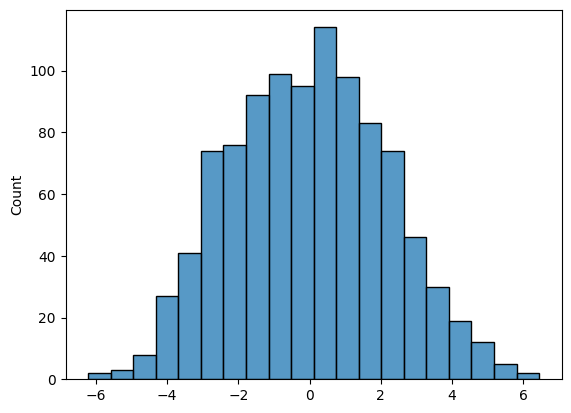

In [464]:
sns.histplot(deltas)

<Axes: ylabel='Count'>

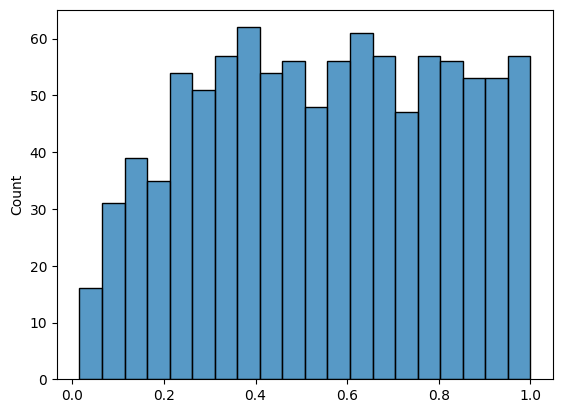

In [465]:
sns.histplot(pvalues, bins=20)

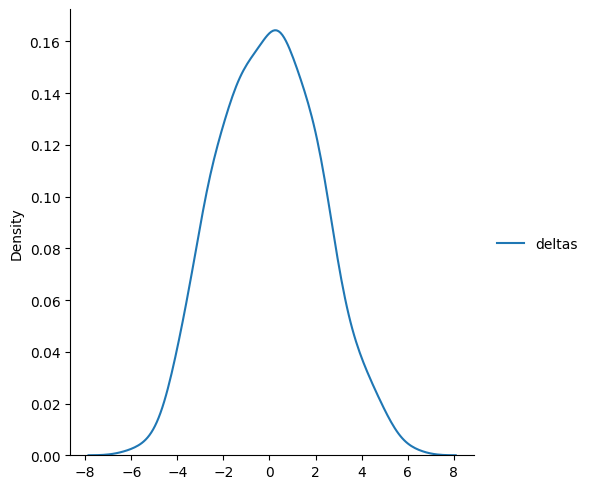

In [466]:
sns.displot(
    {'deltas': deltas},
    kind='kde'
)

<Axes: >

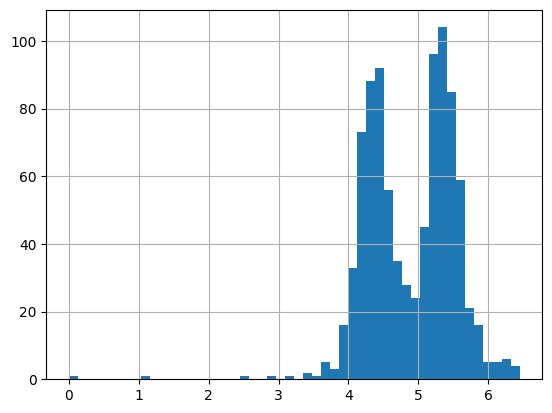

In [467]:
np.log(data[data[config['aggregator']] > 0][config['aggregator']]).hist(bins=50)

<Axes: >

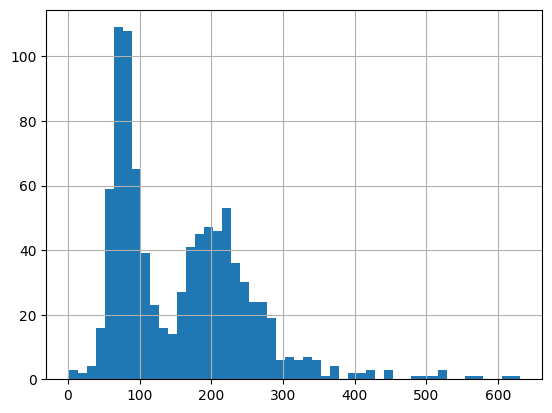

In [468]:
data[data[config['aggregator']] > 0][config['aggregator']].hist(bins=50)

In [430]:
data[config['aggregator']]

0      175
1      201
2       59
3      177
4      264
      ... 
903     97
904     98
905     74
906     48
907    274
Name: action_order_success, Length: 908, dtype: int64

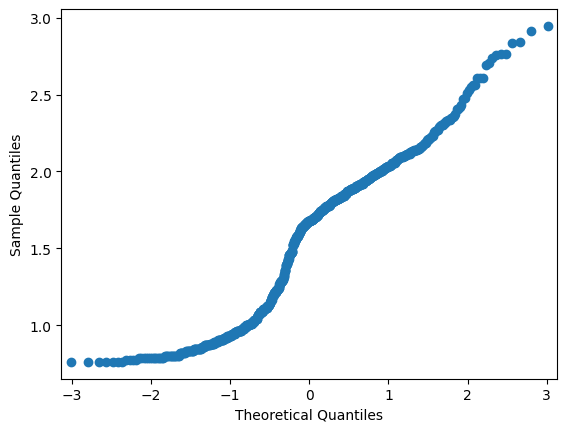

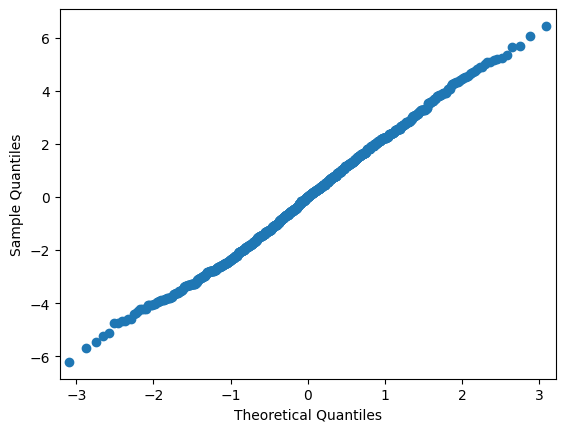

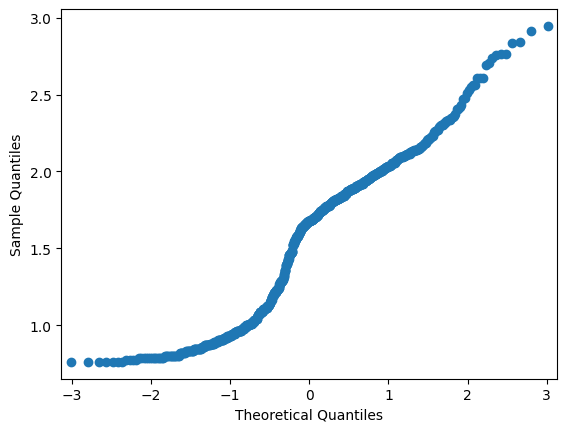

In [469]:
sm.qqplot(np.array(deltas))
sm.qqplot(np.log(data[data[config['aggregator']] > data[config['aggregator']].quantile(0.15)][config['aggregator']])-3.5)

In [432]:
test

,event_date,restraunt_id,session_count,tap_auth_count,tap_email_count,tap_sms_count,action_order_start,action_order_success,action_auth_order_success,revenue,avg_product_count,conversion_rate_total,conversion_rate_auth,TRX,strat,group
29,2023-12-07,74021620,71,0,0,0,71,45,0,23766.0,2.977778,0.633803,0.000000,4719,0.0_0.0,Control best
30,2023-12-08,74021029,259,0,0,0,259,207,3,106557.0,3.478261,0.799228,0.011583,13138,0.0_1.0,Control best
31,2023-12-08,74321793,270,0,0,0,270,238,4,101978.0,3.243697,0.881481,0.014815,13249,0.0_1.0,Control best
33,2023-12-05,74221444,88,0,0,0,88,64,0,34876.0,3.359375,0.727273,0.000000,4794,0.0_0.0,Control best
34,2023-12-06,74020799,75,0,0,0,75,63,3,33132.0,3.349206,0.840000,0.040000,4930,0.0_0.0,Control best
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,2023-11-12,74321793,232,0,0,0,232,180,1,67012.0,2.933333,0.775862,0.004310,13249,0.0_1.0,Control best
895,2023-11-09,74221444,114,0,0,0,114,82,1,41701.0,3.024390,0.719298,0.008772,4794,0.0_0.0,Control best
896,2023-11-07,74020661,205,0,0,0,205,142,1,65262.0,3.000000,0.692683,0.004878,13225,0.0_1.0,Control best
900,2023-11-06,74020799,119,0,0,0,119,78,0,35907.0,3.243590,0.655462,0.000000,4930,0.0_0.0,Control best


In [470]:
import scipy.stats as stats

#Levene's test centered at the median
stats.levene(test[config['aggregator']], control[config['aggregator']], center='mean')


LeveneResult(statistic=0.028664181900320346, pvalue=0.8656121473491953)

In [471]:
test.action_order_success.var()

7133.492940473245

In [472]:
control.action_order_success.var()

7276.629087524852

In [473]:
control.action_order_success.mean()

153.85064935064935

In [474]:
test.action_order_success.mean()

153.65705128205127

In [475]:
t = (control.action_order_success.mean() - test.action_order_success.mean()) / \
  np.sqrt(control.action_order_success.var()/control.action_order_success.count() + test.action_order_success.var()/test.action_order_success.count())
t

0.0283939023342471

In [476]:
pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))
pvalue

0.9773479874745492